# bayesloop tutorial

This notebook is designed to provide a step-by-step guide describing the main features of [*bayesloop*](http://christophmark.github.io/bayesloop/). The tutorial is mainly based on a real-world data set that has been studied extensively in the literature (see this [article](http://www.dima.unige.it/~riccomag/Teaching/ProcessiStocastici/coal-mining-disaster-original%20paper.pdf), or this [review article](http://onlinelibrary.wiley.com/doi/10.1111/jtsa12035/full#jtsa12035-sec-0026) and the references therein). It consists of the annual number of coal mining disasters in the United Kingdom from 1852 to 1961.

**Contents**
1. [Basic data study](#section_1)<br>
  1.1 [Study class](#section_1.1)<br>
  1.2 [Data import](#section_1.2)<br>
  1.3 [Observation model](#section_1.3)<br>
  1.4 [Transition model](#section_1.4)<br>
  1.5 [Parameter grid](#section_1.5)<br>
  1.6 [Model fit](#section_1.6)<br>
  1.7 [Plotting](#section_1.7)<br>
  1.8 [Saving studies](#section_1.8)<br>
2. [Model selection](#section_2)<br>
  2.1 [Bayes factor](#section_2.1)<br>
  2.2 [Combined transition models](#section_2.2)<br>
  2.3 [Serial transition models](#section_2.3)<br>
3. [Model optimization](#section_3)<br>
  3.1 [Optimization of hyper-parameters](#section_3.1)<br>
  3.2 [Selective optimization in nested transition models](#section_3.2)<br>
4. [Hyper-study](#section_4)
5. [Change-point study](#section_5)<br>
  5.1 [Analyzing abrupt changes of parameter values](#section_5.1)<br>
  5.2 [Analyzing structural breaks in time series models](#section_5.2)<br>
6. [Online study](#section_6)
7. [Prior distributions](#section_7)<br>
  7.1 [Parameter priors](#section_7.1)<br>
  7.2 [Hyper-parameter priors](#section_7.2)<br>
8. [Custom observation models](#section_8)<br>
  8.1 [Sympy.stats random variables](#section_8.1)<br>
  8.2 [Scipy.stats probability distributions](#section_8.2)<br>
9. [Multiprocessing](#section_9)

<a id='section_1'></a>
## 1. Basic data study
The first section of the tutorial introduces the main class of the module, `Study`. We provide a detailed description of how to import data, set the observation model and transition model, specify the parameter grid and perform the model fit. Finally, a plotting function to display the results is discussed briefly.

<a id='section_1.1'></a>
### 1.1 Study class
To start a new data study/analysis, create a new instance of the `Study` class:

In [1]:
import bayesloop as bl

S = bl.Study()

+ Created new study.


This object is central to an analysis conducted with *bayesloop*. It stores the data and further provides the methods to perform probabilistic inference on the models defined within the class, as described below.

<a id='section_1.2'></a>
### 1.2 Data import
In this first study, we use a simple, yet instructive example of heterogeneous time series, the annual number of coal mining accidents in the UK from 1851 to 1962. The data is imported as a NumPy array:

In [2]:
import numpy as np

data = np.array([5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4,
                 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0,
                 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
                 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 3, 0,
                 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

S.loadData(data)

+ Successfully imported array.


Note that this particular data set is also hard-coded into the `Study` class, for convenient testing:

In [3]:
S.loadExampleData()

+ Successfully imported example data.


In case you have multiple observations for each time step, you may also provide the data in the form `np.array([[x1,y1,z1], [x2,y2,z2], ..., [xn,yn,zn]])`. Missing data points should be included as `np.nan`.

<a id='section_1.3'></a>
### 1.3 Observation model
The first step to create a probabilistic model to explain the data is to define the **observation model**, or **likelihood**. The observation model states the probability (density) of a data point at time $t$, given the parameter values at time $t$ and possibly past data points.

As coal mining disasters fortunately are rare events, we may model the number of accidents per year by a [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution (data from subsequent years is assumed to be uncorrelated):

In [4]:
M = bl.observationModels.Poisson()
S.setObservationModel(M)

+ Observation model: Poisson. Parameter(s): ['lambda']


Note that you can also use the following short form to define observation models: `M = bl.om.Poisson()`. All currently implemented observation models can be looked up in `observationModels.py`. *bayesloop* further supports all probability distributions that are included in the [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html) as well as the [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) module. See [Sect. 8](#section_8) for instructions on how to build custom observation models from arbitrary distributions.

<a id='section_1.4'></a>
### 1.4 Transition model
As the dynamics of many real-world systems are the result of a multitude of underlying processes that act on different spatial and time scales, common statistical models with static parameters often miss important aspects of the systems' dynamics (see e.g. this [article](http://www.nature.com/articles/ncomms8516)). *bayesloop* therefore calls for a second model, the **transition model**, which describes the temporal changes of the model parameters.

As stated above, we model the observed data by a Poisson distribution with one parameter, the rate $\lambda$ (decribing the average number of disasters per year). While the list of parameters of the chosen observation model is displayed on definition, you may also retrieve it directly:

In [5]:
M.parameterNames

['lambda']

In this example, we assume that $\lambda$ itself may change gradually over time and choose a Gaussian random walk with the standard deviation $\sigma=0.2$ as transition model. The value of the Hyper-parameter $\sigma$ is set from the beginning, but can be optimized (see [Sect. 3](#section_3)).

In [6]:
K = bl.transitionModels.GaussianRandomWalk(sigma=0.3)
S.setTransitionModel(K)

+ Transition model: Gaussian random walk


Note that you can also use the following short form to define transition models: `M = bl.tm.GaussianRandomWalk()`. All currently implemented transition models can be looked up in `transitionModels.py`.

<a id='section_1.5'></a>
### 1.5 Parameter grid
While many inference algorithms designed for hierarchical time series analysis rely on [MCMC](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf) techniques, *bayesloop* chooses a grid-based approach. All probability distributions are discretized on a regular grid of parameter values. While this approach restricts the choice of observation models to those with only few parameters, it allows to perform very fast probabilistic inference, model selection and model optimization.

The parameter grid has be configured prior to calling any fit- or optimization-routine. First, the grid size has to be set for each parameter (here, only $\lambda$):

In [7]:
S.setGridSize([1000])

+ Grid size: [1000]


Second, parameter boundaries have to be set. One has to provide a list of lists, where each inner list consists of a lower and an upper boundary value. Note that choosing the boundaries to narrow may negatively affect the outcome of the analysis. In case the inferred parameter values come close to the boundary values, one should consider re-running the analysis with looser boundaries.

In our example, we restrict the annual disaster rate to the interval $[0,6]$. We will see that this is sufficient when plotting the results below.

In [8]:
S.setBoundaries([[0, 6]])

+ Boundaries: [[0, 6]]


Note that if you do not provide a proper grid size, *bayesloop* will set it automatically to the default value stored in each observation model. In case no parameter boundaries are given, *bayesloop* will try to estimate suitable values based on the data set at hand, at least for the subset of the implemented observation models for which such an estimation is easily possible.

Instead of specifying grid size and parameter boundaries by separate calls of `setGridSize` and `setBoundaries`, the parameter grid can also be specified by a single call of the method `setGrid`:

In [9]:
S.setGrid([[0, 6, 1000]])

+ Boundaries: [[0, 6]]
+ Grid size: [1000]


<a id='section_1.6'></a>
### 1.6 Model fit

At this point, the hierarchical time series model for the coal mining data set is properly defined and we may continue to perform the model fit. *bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). The inference algorithm is implemented by the `fit` method:

In [10]:
S.fit()

+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -74.40774
    + Finished backward pass.
    + Computed mean parameter values.


By default, `fit` computes the so-called *smoothing distribution* of the model parameters for each time step. This distribution states the probability (density) of the parameter value at a time step $t$, given all past and future data points. All distributions have the same shape as the parameter grid, and are stored in `S.posteriorSequence` for further analysis. Additionally, the mean values of each distribution are stored in `S.posteriorMeanValues`, as point estimates. Finally, the (natural) logarithmic value of the evidence, the probability of the data given the chosen model, is stored in `S.logEvidence` (see [Sect. 2](#section_2)). 

To simulate an online-analysis, where at each step in time $t$, only past data points are available, one may provide the keyword-argument `forwardOnly=True`. In this case, only the *forward*-part of the algorithm in run. The resulting parameter distributions are called *filtering distributions*.

<a id='section_1.7'></a>
### 1.7 Plotting
To display the temporal evolution of the model parameters, the `Study` class provides a simple plot method `plotParameterEvolution` that displays the mean values together with the marginal distributions for one parameter of the model. The parameter to be plotted can be chosen by providing an index or the name of the parameter (by default, the first one is plotted).

Here, we plot the original data (in red) together with the inferred disaster rate (mean value in black). The marginal parameter distribution is displayed as a blue overlay, by default with a gamma correction of $\gamma=0.5$ to enhance relative differences in the width of the distribution (this behavior can be changed by the keyword argument `gamma`):

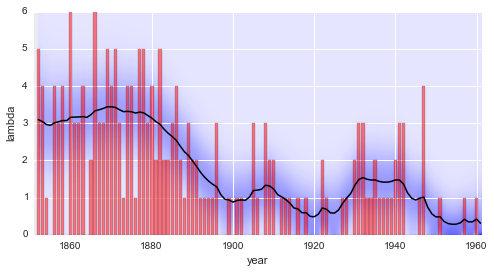

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# plot of raw data
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)

# parameter plot
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)

plt.xlim([1851, 1961])
plt.xlabel('year')

From this first analysis, we may conclude that before 1880, an average of $\approx 3$ accidents were recorded. This changes significantly between 1880 and 1900, when the accident-rate drops to $\approx 1$. Studies like this one may in the future help to objectively quantify the effects of policies, like safety regulations.

<a id='section_1.8'></a>
### 1.8 Saving studies
As the `Study` class instance (above denoted by `S`) of a conducted analysis contains all information about the inferred parameter values, it may be convenient to store the entire instance `S` to file. This way, it can be loaded again later, for example to refine the study, create different plots or perform further analyses based on the obtained results. *bayesloop* provides two functions, `bl.save()` and `bl.load()` to store and retrieve existing studies. To be able to use these functions, the module [dill](https://pypi.python.org/pypi/dill) (an extension to the Python module [pickle](https://docs.python.org/2/library/pickle.html)) has to be installed. An easy way to obtain dill is by using the package manager [pip](https://pypi.python.org/pypi/pip):
```
pip install dill
```
Note that saving studies to file is considered an optional feature, so dill is not installed as a requirement when installing *bayesloop*.

<a id='section_2'></a>
## 2 Model Selection

In Bayesian statistics, an objective model comparison is carried out by comparing the models' [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood). The likelihood function describes the probability (density) of the data, given the parameter values (and thereby the chosen model). By integrating out (marginalizing) the parameter values, one obtains the marginal likelihood (or model evidence), which directly measures the fitness of the model at hand. The model evidence represents a powerful tool for model selection, as it does not assume specific distributions (e.g. [Student's t-test](https://en.wikipedia.org/wiki/Student's_t-test) assumes Gaussian distributed variables) and automatically follows the principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor).

The forward-backward algorithm that *bayesloop* relies on allows to approximate the marginal likelihood based on the discretized parameter distributions. Details on this method in the context of Hidden Markov models can be found [here](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf).

This section aims at giving a very brief introduction of Bayes factors together with an example based on the coal mining data and further introduces combined transition models in *bayesloop*.

<a id='section_2.1'></a>
### 2.1 Bayes factor

Instead of interpreting the value of the marginal likelihood for a single model, it is common to compare two competing models/explanations $M_1$ and $M_2$ by evaluating the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor), here denoted as $B_{12}$. The Bayes factor is given by the ratio of the two marginal likelihood values:

$$B_{12} = \frac{p(D|M_1)}{p(D|M_2)}$$

where $p(D|M_i)$ states the probability of the data (marginal likelihood) given model $M_i$. A value of $B_{12} > 1$ therefore indicates that the data is better explained by model $M_1$, compared to $M_2$. More detailed information for the interpretation of the value of Bayes factors can be found [here](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) and in the references therein.

As a first example, we investigate whether the inferred disaster rate of the coal mining data set indeed should be modeled as a time-varying parameter (a constant rate is an equally valid hypothesis). We first fit the model using the `GaussianRandomWalk` model with a standard deviation of $\sigma = 0.2$ (shown in the plot in [Sect. 1.7](#section_1.7)) to determine the corresponding marginal likelihood (on a log scale). Subsequently, we use the simpler `Static` transition model (assuming no change of the disaster rate over time) and compare the resulting marginal likelihood by computing the Bayes factor. Note that for computational efficiency, the keyword argument `evidenceOnly=True` is used, which evaluates the model evidence, but does not store any results for plotting.

In [12]:
# dynamic disaster rate
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)
S.fit(evidenceOnly=True)

dynamicLogEvidence = S.logEvidence

#static disaster rate
K = bl.transitionModels.Static()
S.setTransitionModel(K)
S.fit(evidenceOnly=True)

staticLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence - staticLogEvidence)
print '\nBayes factor: B =', B

+ Transition model: Gaussian random walk
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -74.59055
+ Transition model: Static/constant parameter values
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -88.00564

Bayes factor: B = 2.60066520417e+13


The computed Bayes factor $B = 2.6 \cdot 10^{13}$ shows [decisive](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) support for the first hypothesis of a dynamic disaster rate.

While this analysis conducted above clearly rules for a time-varying rate, there may still exist a dynamic model that represents a better fit than the Gaussian random walk with $\sigma=0.2$. A very simple dynamic model is given by the transition model `ChangePoint` that assumes an abrupt change of the disaster rate at a predefined point in time, we choose 1890 here. Note that we perform a full fit in this case, as we want to provide a plot of the result:

+ Transition model: Change-point model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -74.52798
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 1.15498113987


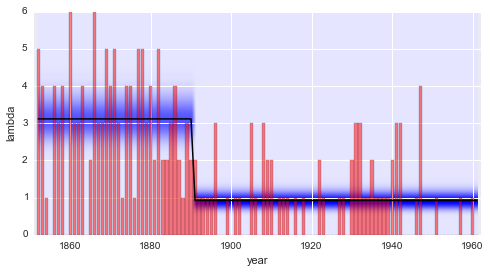

In [13]:
# dynamic disaster rate (change-point model)
K = bl.transitionModels.ChangePoint(tChange=38)  # the 39nd data point (index 38) corresponds to 1890
S.setTransitionModel(K)
S.fit()

dynamicLogEvidence2 = S.logEvidence

# determine Bayes factor
B = np.exp(dynamicLogEvidence2 - dynamicLogEvidence)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

The Bayes factor shows support in favor of the change-point model, compared to the Gaussian random walk model. However, the low value of $B = 1.15$ indicates only very weak support and is [not worth more than a bare mention](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation). Based on the data at hand, no clear decision between the two models can be made. While the change-point model is favored because it is more restricted (the number of possible data sets that can be decribed by this model is much smaller than for the Gaussian random walk) and therefore *"simpler"*, it cannot capture fluctuations of the disaster rate before and after 1890 like the Gaussian random walk model does.

<a id='section_2.2'></a>
### 2.2 Combined transition models

The discussion above shows that depending on the data set, different transition models better explain different aspects of the data. For some data sets, a satisfactory transition model may only be found by combining several simple transition models. *bayesloop* provides a transition model class called `CombinedTransitionModel` that can be supplied with a sequence of transition models that are subsequently applied at every time step. Here, we combine the change-point model and the Gaussian random walk model to check whether the combined model yields a better explanation of the data, compared to the change-point model alone:

+ Transition model: Combined transition model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -74.09016
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 2.74041317525


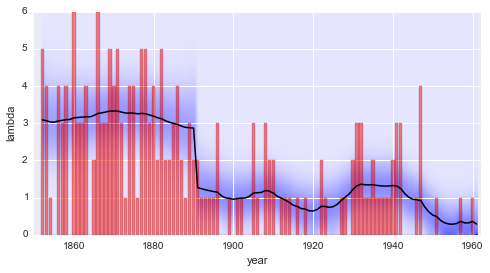

In [14]:
# combined model (change-point model + Gaussian random walk)
K = bl.transitionModels.CombinedTransitionModel(bl.transitionModels.ChangePoint(tChange=38),
                                                bl.transitionModels.GaussianRandomWalk(sigma=0.2))
S.setTransitionModel(K)
S.fit()

combinedLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(combinedLogEvidence - dynamicLogEvidence2)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

Again, the refined model is favored by a Bayes factor of $B = 2.74$. However, the gain in evidence compared to the change-point model is [not worth more than a bare mention](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation).

<a id='section_2.3'></a>
### 2.3 Serial transition model

The combined transition models introduced above substantially extend the number of different transition models. These transition models imply identical parameter dynamics for all time steps. In many real-time applications, there exist so-called structural breaks when parameter dynamics exhibit a fundamental change. In contrast to an abrupt change of the parameter values in case of a change-point (c.f. [Sect. 2.1](#section_2.1)), a structural break indicates an abrupt change of the transition model at a specific point in time. The class `SerialTransitionModel` allows to define a sequence of transition models (including combined transition models) together with a sequence of time steps that denote the structural breaks.

We use this new class of transition model to explore the idea that the number of coal mining disasters did not decrease instantaneously, but instead decreased linearly over the course of a few years. We assume a static disaster rate until 1885, followed by a deterministic decrease of 0.2 disasters per year (using the `Linear` transition model) until 1895. Finally, the disaster rate after the year 1895 is modelled by a Gaussian random walk of the disaster rate with a standard deviation of $\sigma=0.1$. Note that we pass the transition models and the corresponding structural breaks (time steps) to the `SerialTransitionModel` in turns. While this order may increase readability, one can also pass the models first, followed by the corresponding time steps.

+ Transition model: Serial transition model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -72.93384
    + Finished backward pass.
    + Computed mean parameter values.

Bayes factor: B = 14.3325202236


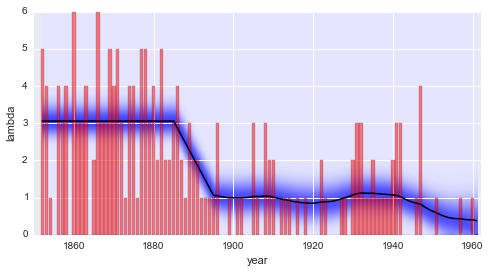

In [15]:
K = bl.transitionModels.SerialTransitionModel(bl.transitionModels.Static(),
                                              33, # 1885
                                              bl.transitionModels.Linear(slope=-0.2),
                                              43, # 1895
                                              bl.transitionModels.GaussianRandomWalk(sigma=0.1))
S.setTransitionModel(K)
S.fit()

serialLogEvidence = S.logEvidence

# determine Bayes factor
B = np.exp(serialLogEvidence - combinedLogEvidence)
print '\nBayes factor: B =', B

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1850, 1962])
plt.xlabel('year')

The Bayes factor of the serial model compared to the combined model from [Sect. 2.2](#section_2.2) is determined to $B = 11.38$. This value indicates [positive/strong](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation) evidence in favor of the serial model. Keep in mind, though, that the time steps of the structural breaks and the slope of the linear decrease are not inferred in this example, but are instead set by the user. The determined Bayes factor therefore relies on the assumption that these values are true, and the uncertainty tied to these values is therefore not reflected in the value of the Bayes factor. More elaborate studies that take into account the uncertainty tied to these hyper-parameters are introduced in Sects. [4](#section_4) and [5](#section_5).

The iterative approach of creating new hypotheses and comparing them to the best hypothesis currently available provides an objective and never-the-less straight-forward way of exploring new data sets. The subsequent section provides methods to improve upon values for hyper-parameters that are *"blindly"* set by the user.

<a id='section_3'></a>
## 3 Model optimization

The model evidence cannot only be used to compare different kinds of time series models, but also to optimize the hyper-parameters of a given transition model by maximizing its evidence value. The `Study` class of *bayesloop* contains a method `optimize` which relies on the `minimize` function of the `scipy.optimize` module. Since *bayesloop* has no gradient information about the hyper-parameters, the optimization routine is based on the [COBYLA](https://en.wikipedia.org/wiki/COBYLA) algorithm. The following two sections introduce the optimization of hyper-parameters using *bayesloop* and further describe how to selectively optimize specific hyper-parameters in nested transition models.

<a id='section_3.1'></a>
### 3.1 Optimization of hyper-parameters

The `optimize` method supports all currently implemented transition models with continuous hyper-parameters, as well as combinations of multiple models. The change-point model as well as the serial transition model represent exceptions here, as their parameters `tChange` and `tBreak`, respectively, are discrete. These discrete pratemers are ignored by the optimization routine. See [Sect. 5](#section_5) for further information on how to analyze structural breaks and change-points. By default, all continuous hyper-parameters of the transition model are optimized. *bayesloop* further allows to selectively optimize specific hyper-parameters, see [Sect. 3.2](#section_3.2). The parameter values set by the user when defining the transition model are used as starting values. During optimization, only the log-evidence of the model is computed. When finished, a full fit is done to provide the parameter distributions and mean values for the optimal model setting.

We take up the coal mining example again, and stick with the serial transition model defined in [Sect. 2.3](#section_2.3). This time, however, we optimize the slope of the linear decrease from 1885 to 1895 and the magnitude of the fluctuations afterwards (i.e. the standard deviation of the Gaussian random walk):

+ Starting optimization...
  --> All model parameters are optimized (except change/break-points).
    + Log10-evidence: -72.93384 - Parameter values: [-0.2  0.1]
    + Log10-evidence: -96.81252 - Parameter values: [ 0.8  0.1]
    + Log10-evidence: -75.18192 - Parameter values: [-0.2  1.1]
    + Log10-evidence: -78.43877 - Parameter values: [-1.19559753  0.00626873]
    + Log10-evidence: -78.80509 - Parameter values: [-0.69779877  0.05313437]
    + Log10-evidence: -85.79404 - Parameter values: [ 0.04572939  0.05398839]
    + Log10-evidence: -72.76628 - Parameter values: [-0.21058883  0.34977565]
    + Log10-evidence: -73.72301 - Parameter values: [-0.33553394  0.34607154]
    + Log10-evidence: -74.02943 - Parameter values: [-0.08663732  0.3659319 ]
    + Log10-evidence: -73.17022 - Parameter values: [-0.14861308  0.35785378]
    + Log10-evidence: -72.79393 - Parameter values: [-0.21462789  0.38076353]
    + Log10-evidence: -72.92776 - Parameter values: [-0.27089564  0.33336413]
    + Lo

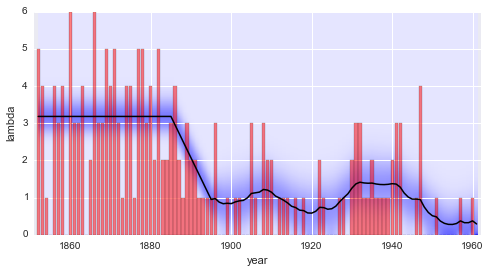

In [16]:
S.optimize()

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

The optimal value for the standard deviation of the varying disaster rate is determined to be $\approx 0.26$, the initial guess of $\sigma = 0.1$ is therefore too restrictive. The value of the slope is only optimized slightly, resulting in an optimal value of $\approx -0.22$. The optimal hyper-parameter values are displayed in the output during optimization, but can also be inspected directly. Since we use a transition model that consists of multiple sub-models, we have to denote the corresponding sub-model of the hyper-parameter:

In [17]:
print S.transitionModel.models[1].hyperParameters['slope']
print S.transitionModel.models[2].hyperParameters['sigma']

-0.223200424799
0.228499363226


For a non-combined/non-serial transition model, the attribute `hyperParameters` can be accessed directly:

In [18]:
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)

print S.transitionModel.hyperParameters['sigma']

+ Transition model: Gaussian random walk
0.2


<a id='section_3.2'></a>
### 3.2 Selective optimization in nested transition models

The previous section introduced the `optimize` method of the `Study` class. By default, all (continuous) hyper-parameters of the chosen transition model are optimized. In some applications, however, only specific hyper-parameters may be subject to optimization. Therefore, a list of parameter names (or a single name) may be passed to `optimize`, specifying which parameters to optmize. This fairly straight-forward way of specifying the hyper-parameters of interest gets more complicated for nested transition models with multiple hyper-parameters that share an identical name. An example for such a (quite ridiculously) nested transition model is defined below:

In [19]:
K = bl.tm.SerialTransitionModel(bl.tm.CombinedTransitionModel(
                                    bl.tm.GaussianRandomWalk(sigma=0.05),
                                    bl.tm.RegimeSwitch(log10pMin=-7)
                                    ),
                                33, # 1885
                                bl.tm.Linear(slope=-0.2),
                                43, # 1895
                                bl.tm.CombinedTransitionModel(
                                    bl.tm.GaussianRandomWalk(sigma=0.25),
                                    bl.tm.Linear(slope=0.0)
                                    )
                                )
S.setTransitionModel(K)

+ Transition model: Serial transition model


This transition model assumes a combination of gradual and abrupt changes until $1885$, followed by a deterministic decrease of the annual disaster rate until $1895$. Afterwards, the disaster rate is modeled by a combination of a decreasing trend and random fluctuations. Instead of discussing exactly how meaningful the proposed transition model really is, we focus on how to specify different (groups of) hyper-parameters that we might want to optimize.

All hyper-parameter names that occur only once within the transition model may simply be stated by their name: `S.optimize('log10pMin')`. Note that you may also pass a single hyper-parameter as a list: `S.optimize(['log10pMin'])`.

In case a parameter name occurs multiple times, *bayesloop* selects them in the order that they appear in. `S.optimize('sigma')` will only optimize the first occurrence of `sigma` (before 1885), while `S.optimize(['sigma', 'sigma'])` will optimize both hyper-parameters of the gaussian random walks.

Additional notation is needed in the case that only the second (or third, forth, ...) occurrence of a hyper-parameter name is to be optimized. Here, you have to specify the sub-model to which the hyper-parameter of interest belongs to. Suppose you want to optimize the `slope` parameter after 1895. This hyper-parameter is part of the __third sub-model of the serial transition model__, as it describes a part of the parameter dynamics after 1895. However, the third sub-model of the serial transition model is itself a combined transition model. The `Linear model` that contains the `slope` hyper-parameter represents the __second sub-sub-model of the combined sub-model__. We can thus optimize this hyper-parameter by calling:

In [20]:
S.optimize(['slope_3_2'])

+ Starting optimization...
  --> Parameter(s) to optimize: ['slope_3_2']
    + Log10-evidence: -72.78374 - Parameter values: [ 0.]
    + Log10-evidence: -93.84904 - Parameter values: [ 1.]
    + Log10-evidence: -81.02369 - Parameter values: [-1.]
    + Log10-evidence: -85.81431 - Parameter values: [-0.5]
    + Log10-evidence: -82.83324 - Parameter values: [ 0.25]
    + Log10-evidence: -73.27819 - Parameter values: [-0.125]
    + Log10-evidence: -74.00232 - Parameter values: [ 0.0625]
    + Log10-evidence: -72.56582 - Parameter values: [-0.03125]
    + Log10-evidence: -72.59036 - Parameter values: [-0.0625]
    + Log10-evidence: -72.64333 - Parameter values: [-0.015625]
    + Log10-evidence: -72.54999 - Parameter values: [-0.0390625]
    + Log10-evidence: -72.54902 - Parameter values: [-0.046875]
    + Log10-evidence: -72.55401 - Parameter values: [-0.05078125]
    + Log10-evidence: -72.54789 - Parameter values: [-0.04492188]
    + Log10-evidence: -72.54767 - Parameter values: [-0.04296

This method of indexing hyper-parameters works for arbitrily nested transition models and can also be used by the extended study-classes `HyperStudy` and `ChangepointStudy`, which are described in detail in [Sect. 4](#section_4) and [Sect. 5](#section_5), respectively.

<a id='section_4'></a>
## 4 Hyper-study

The time series models built with the help of *bayesloop* are called [hierarchical models](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling), since the parameters of the observation model are in turn controlled by hyper-parameters that are possibly included in the transition model. In the [previous section](#section_3), we optimized two hyper-parameters of a serially combined transition model: the slope of the decrease in coal mining disasters from 1885 to 1895, and the magnitude of the fluctuations afterwards. While the optimization routine yields the most probable values of these hyper-parameters, one might also be interested in the uncertainty tied to these *"optimal"* values. *bayesloop* therefore provides the `HyperStudy` class that allows to compute the full distribution of hyper-parameters by defining a discrete grid of hyper-parameter values.

While the `HyperStudy` instance can be configured just like a standard `Study` instance, the new method `setHyperGrid` allows to define a regular grid of hyper-parameter values to be evaluated during the analysis. The hyper-parameter grid passed to `setHyperGrid` represents a list of lists, and each sub-list contains the name, a lower boundary, an upper boundary and the number of steps in between those boundaries (similar to the [numpy.linspace](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) function). In the example below, we return to the serial transition model used in [Sect. 3.1](#section_3.1) and compute a two-dimensional distribution of the two hyper-parameters `slope` (20 steps from -0.4 to 0.0) and `sigma` (20 steps from 0.0 to 0.8). Note that the `fit` method by default shows output for each of the 400 value-tuples. As this is not desirable in the notebook environment, we set the keyword-argument `silent=True`.

After running the fit-method for all value-tuples of the hyper-grid, average parameter distributions are computed based on the model evidence of all fits. This average parameter distribution allows to assess the temporal evolution of the model parameters, explicitely considering the uncertainty of the hyper-parameters. However, in case one is only interested in the hyper-parameter distribution, setting the keyword-argument `evidenceOnly=True` of the `fit` method shortens the computation time but skips the evaluation of parameter distributions.

Finally, *bayesloop* provides several methods to plot the results of the hyper-study. To display the joint distribution of two hyper-parameters, choose `plotJointHyperParameterDistribution`. Here, the keyword-argument `params` represents a list of two hyper-parameter names as defined in `setHyperGrid`, or simply two indices. By default, the first two hyper-parameters will be plotted. The method automatically computes the [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) for the two specified hyper-parameters. The visualization is done using the `bar3d` function from the [mpl_toolkits.mplot3d](http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html) module.

+ Created new study.
  --> Hyper-study
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['lambda']
+ Grid size: [100]
+ Boundaries: [[0, 6]]
+ Transition model: Serial transition model
+ Set hyper-grid for the following hyper-parameters:
  ['slope', 'sigma']
+ Started new fit.
    + 400 analyses to run.
    + Log10-evidence of average model: -73.42626
+ Finished fit.
17.5586358762


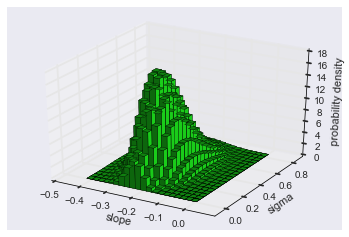

In [21]:
HS = bl.HyperStudy()
HS.loadExampleData()

M = bl.om.Poisson()
HS.setObservationModel(M)

HS.setGridSize([100])
HS.setBoundaries([[0, 6]])

K = bl.transitionModels.SerialTransitionModel(bl.transitionModels.Static(),
                                              33,
                                              bl.transitionModels.Linear(slope=-0.2),
                                              43,
                                              bl.transitionModels.GaussianRandomWalk(sigma=0.1))

HS.setTransitionModel(K)

HS.setHyperGrid([['slope', -0.4, 0.0, 20], ['sigma', 0.0, 0.8, 20]])

HS.fit(silent=True)
HS.plotJointHyperParameterDistribution(params=[0, 1], color=[0.1, 0.8, 0.1])

plt.xlim([-0.5, 0.1])
plt.ylim([-0.1, 0.9]);

It is important to note here, that the evidence value of $\approx 10^{-74.3}$ is smaller compared to the value of $\approx 10^{-73.5}$ obtained by the analysis in [Sect. 3.1](#section_3.1). In Sect. 3.1, we optimized the hyper-parameter values and assumed that these optimal values are not subject to uncertainty, therefore over-estimating the model evidence. In contrast, the hyper-study explicitely considers the uncertainty tied to the hyper-parameter values.

While the joint distribution of two hyper-parameters may uncover possible correlations between the two quantities, the 3D plot is often difficult to integrate into existing figures. `HyperStudy` therefore also provides the method `plotHyperParameterDistribution` that shows the marginal distribution of a single hyper-parameter in a simple 2D histogram/bar plot:

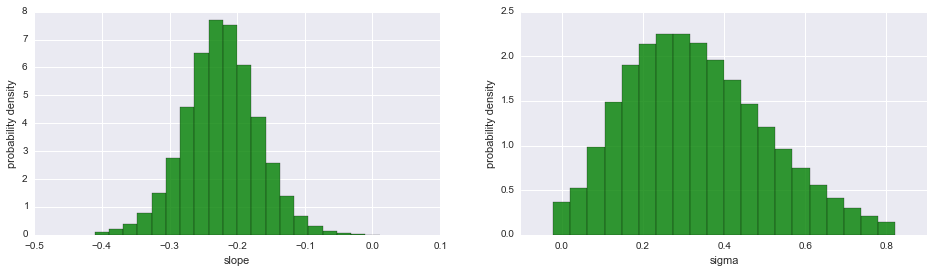

In [22]:
plt.figure(figsize=(16,4))
plt.subplot(121)
HS.plotHyperParameterDistribution(param='slope', color='g', alpha=.8);

plt.subplot(122)
HS.plotHyperParameterDistribution(param='sigma', color='g', alpha=.8);

Finally, the temporal evolution of the model parameters may be displayed as already described in [Sect. 1.7](#section_1.7), using `plotParameterEvolution`:

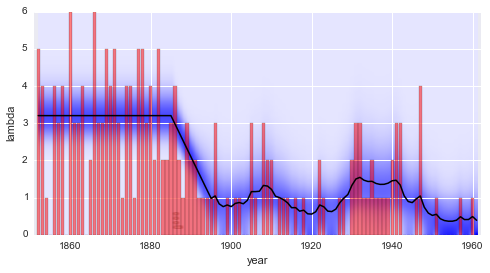

In [23]:
plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
HS.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

<a id='section_5'></a>
## 5 Change-point study

[Change point analysis](http://www.variation.com/cpa/tech/changepoint.html) or [change detection](https://en.wikipedia.org/wiki/Change_detection) deals with abrupt changes in statistical properties of time series. As introduced in [Sect. 2](#section_2), *bayesloop* includes two types abrupt changes: an abrupt change in parameter values is modeled by the transition model `ChangepointModel`. In contrast to this change in value, the transition model itself may change at specific points in time, which we will refer to as *structural breaks*. These structural changes are implemented using the `SerialTransitionModel` class. The following two sections introduce the `ChangepointStudy` class and describe its usage to analyze both change-points and structural breaks in time series data.

<a id='section_5.1'></a>
### 5.1 Analyzing abrupt changes of parameter values

The `ChangepointStudy` class represents an extention of the `HyperStudy` introduced above and provides an easy-to-use interface to conduct change-point studies. By calling the `fit` method, this type of study first analyzes the defined transition model and detects all instances of `ChangepointModel`. Instead of using the predefined change-points provided by the user, it then computes a list of all valid combinations of change-point times and fits them. With Bayesian evidence as an objective fitness measure, this type of study can be used to answer the general question of when changes have happened. Furthermore, we may compute a distribution of change-point times to assess the (un-)certainty of these points in time.

#### Analysis of a single change-point
In a first example, we assume a single change-point in our data set of coal mining disasters. Using the `ChangepointStudy`, we iterate over all possible time steps using the change-point model. After processing all time steps, the probability distribution of the change-point as well as an average model are computed. This study may also be carried out using MCMC methods, see e.g. the [PyMC tutorial](https://pymc-devs.github.io/pymc/tutorial.html) for comparison.

The change-point study is set up as follows:

In [24]:
CPS = bl.ChangepointStudy()
CPS.loadExampleData()

M = bl.om.Poisson()
CPS.setObservationModel(M)

CPS.setGridSize([1000])
CPS.setBoundaries([[0, 6]])

K = bl.tm.ChangePoint(tChange=38)
CPS.setTransitionModel(K)

CPS.fit()

+ Created new study.
  --> Hyper-study
  --> Change-point analysis
+ Successfully imported example data.
+ Observation model: Poisson. Parameter(s): ['lambda']
+ Grid size: [1000]
+ Boundaries: [[0, 6]]
+ Transition model: Change-point model
+ Detected 1 change-point(s) in transition model.
+ Started new fit.
    + 110 analyses to run.
    + Analysis #1 of 110 -- Hyper-parameter values [ 0.] -- log10-evidence = -87.54197
    + Analysis #2 of 110 -- Hyper-parameter values [ 1.] -- log10-evidence = -87.09650
    + Analysis #3 of 110 -- Hyper-parameter values [ 2.] -- log10-evidence = -87.68281
    + Analysis #4 of 110 -- Hyper-parameter values [ 3.] -- log10-evidence = -88.26353
    + Analysis #5 of 110 -- Hyper-parameter values [ 4.] -- log10-evidence = -87.92156
    + Analysis #6 of 110 -- Hyper-parameter values [ 5.] -- log10-evidence = -87.76368
    + Analysis #7 of 110 -- Hyper-parameter values [ 6.] -- log10-evidence = -87.33495
    + Analysis #8 of 110 -- Hyper-parameter values [ 

After all fits are completed, we can plot the change-point distribution, by accessing `CPS.changepointDistribution`. By default, the x-axis simply shows integer time steps, starting at zero. To customize the time axis, use the keyword-argument `tRange`, as in this example:

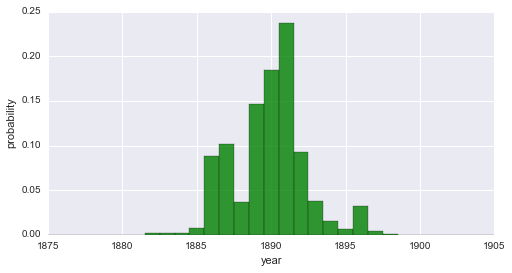

In [25]:
plt.figure(figsize=(8, 4))

CPS.plotChangepointDistribution(tRange=[1852, 1961], color='g', alpha=.8)

plt.xlim([1875, 1905])
plt.xlabel('year')

From this distribution, we may conclude that a change in safety conditions of coal mines in the UK happened sometime between 1886 and 1892, with a probability of $\approx 90\%$.

*bayesloop* further weighs all fitted models by their probability from the change-point distribution and subsequently adds them up, resulting in an average model, which is stored in `CPS.posteriorSequence` and `CPS.posteriorMeanValues`. Additionally, the log-evidence of the average model is set by the weighted sum of all log-evidence values. These results can be plotted as before, using `plotParameterEvolution`:

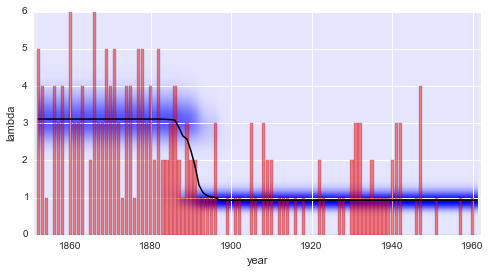

In [26]:
plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), CPS.rawData, align='center', facecolor='r', alpha=.5)
CPS.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

<a id='regime_switching_example'></a>
#### Exploring possible change-points
The change-point study described above explicitely assumes the existience of a single change-point in the data set. Without any prior knowledge of a certain data set, however, this assumption can rarely be made with certainty as the number of potential change-points is often unknown.

In order to *explore* possible change-points withour prior knowledge, *bayesloop* includes the transition model `RegimeSwitch`, which assigns a minimal probability (specified on a log<sub>10</sub>-scale by `log10pMin`) to all parameter values on the parameter grid at every time step. This model allows for abrupt parameter changes only, and neglects gradually varying parameter dynamics.

For the coal mining example, the results from the regime-switching model with a minimal probability of $10^{-7}$ resemble the average model of the change-point study:

+ Transition model: Regime-switching model
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -78.41558
    + Finished backward pass.
    + Computed mean parameter values.


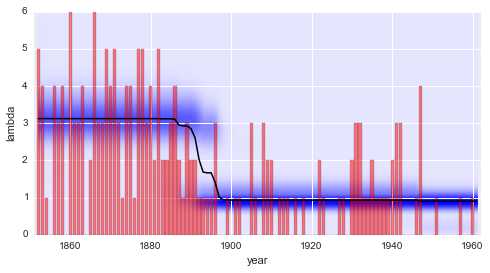

In [27]:
K = bl.transitionModels.RegimeSwitch(log10pMin=-7)
S.setTransitionModel(K)

S.fit()

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

#### Analysis of multiple change-points
Suppose the regime-switching process introduced above indicates two distinct change-points in a data set. In this case, the `ChangepointStudy` class can be used together with a `CombinedTransitionModel` to perform a comprehensive analysis assuming two change-points. The combined transition model here simply consists of two instances of the `ChangePoint` model. We use the example below to investigate possible change-points in the disaster rate after the significant decrease at the end of the 19th century, i.e. restricting the data set to the time after 1900.

After all fits are done, the resulting joint change-point distribution can be plotted using the `plotJointChangepointDistribution` method (similar to plotting the joint distribution of a hyper-study).

+ Successfully imported example data.
+ Transition model: Combined transition model
+ Detected 2 change-point(s) in transition model.
+ Started new fit.
    + 1891 analyses to run.
    + Log10-evidence of average model: -35.68100
+ Finished fit.
0.078887817205


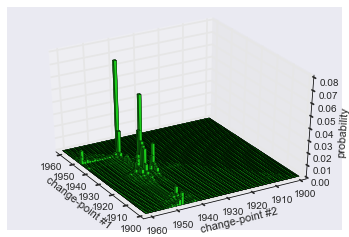

In [28]:
CPS.loadExampleData()
CPS.rawData = CPS.rawData[48:] # restrict analysis to data after 1900

K = bl.tm.CombinedTransitionModel(bl.tm.ChangePoint(tChange=20),
                                  bl.tm.ChangePoint(tChange=40)
                                  )
CPS.setTransitionModel(K)
CPS.fit(silent=True)

CPS.plotJointChangepointDistribution(indices=[0, 1], tRange=[1900, 1961], color=[0.1, 0.8, 0.1])
plt.xlim([1899, 1962])
plt.ylim([1899, 1962])

# set proper view-point
ax = plt.gca()
ax.view_init(elev=35, azim=150)

Instead of focusing on the exact time steps of the change-points, some applications may call for the analysis of the time interval between two change-points. The `ChangepointStudy` class provides a method called `plotDuration` that creates a histogram/bar plot showing the probability for different time intervals between two change-points. Based on the example above, the resulting *"duration distribution"* is shown below:

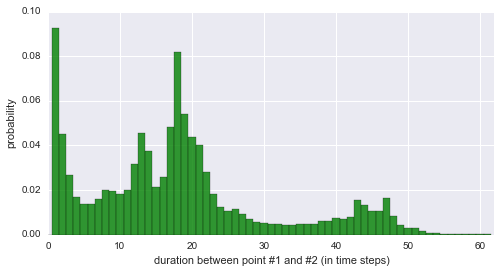

In [29]:
plt.figure(figsize=(8, 4))
CPS.plotDuration(indices=[0, 1], color='g', alpha=.8)
plt.xlim([0, 62]);

Finally, we plot the averaged parameter evolution of the two-change-point model. From the duration distribution as well as from the temporal evolution of the inferred disaster rate we may conclude that there is indeed a time period with an increased disaster rate, which begins in $\approx 1930$ and ends in $\approx 1945$. The duration distribution underlines this finding with high probability values around 15 to 20 years.

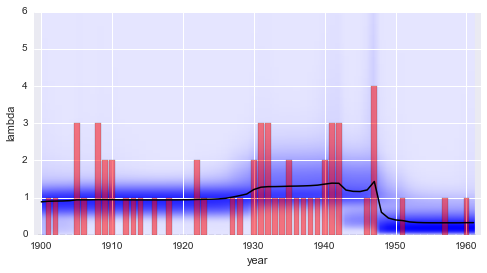

In [30]:
plt.figure(figsize=(8, 4))
plt.bar(range(1900, 1962), CPS.rawData, align='center', facecolor='r', alpha=.5)
CPS.plotParameterEvolution(param='lambda', xLower=1900, xUpper=1962)
plt.xlim([1899, 1962])
plt.xlabel('year')

<a id='section_5.2'></a>
### 5.2 Analyzing structural breaks in time series models
In contrast to a pure change in parameter value, the whole type of parameter dynamics may change at a given point in time. We will use the term *structural break* to describe such events. We have already investigated so-called serial transition models that describe parameter dynamics that change from time to time. While these serial transition models are a re-occurring topic in this tutorial (see Sects. [2.3](#section_2.3), [3](#section_3) and [4](#section_4)), the times at which the structural breaks happen have - up to this point - always been user-defined and fixed. This restriction can be lifted by the `ChangepointStudy` class. If a `SerialTransitionModel` is defined within the change-point study, all structural breaks will be treated as variables and the `fit` method will interate over all possible combinations, just as with *"normal"* change-points.

In this section, our goal is to build a model to determine how long it took for the disaster rate to decrease from $\approx 3$ disasters per year to only $\approx 1$ per year. This kind of study may generally be applied to assess the effectivity of policies like safety regulations. Here, we devise a simple serial transition model that consists of three phases to describe the change in the annual number of coal mining disasters: in the first and the last phase, we assume a constant disaster rate, while the intermediate phase is modelled by a linear decrease of the disaster rate. By providing using the method `setHyperGrid` within the `ChangepointStudy` class, we can combine the advantages of both hyper- and change-point study in order to consider the uncertainty of the change-points *and* the uncertainty of the slope of the intermediate phase. We restrict the data set to the years from 1870 to 1910, and assume an improvement of the disaster rate by 0 to 2.0 disasters per year.

_**Note:** The following analysis consists of ~25000 individual model fits. It may take several minutes to complete._

+ Successfully imported example data.
+ Transition model: Serial transition model
+ Detected 2 break-point(s) in transition model.
+ Additional 1 hyper-parameter(s) specified for rastering:
  ['slope']
+ Started new fit.
    + 24600 analyses to run.
    ! Posterior distribution contains only zeros, check parameter boundaries!
      Stopping inference process. Setting model evidence to zero.
    + Log10-evidence of average model: -30.66023
+ Finished fit.
0.015201115014


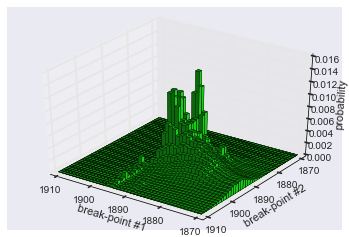

In [31]:
CPS.loadExampleData()
CPS.rawData = CPS.rawData[18:59] # restrict analysis to 1870-1910

K = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                15,
                                bl.tm.Linear(slope=-0.3),
                                30,
                                bl.tm.Static()
                                )

CPS.setTransitionModel(K)
CPS.setHyperGrid([['slope', -2.0, 0.0, 30]])
CPS.fit(silent=True) #, evidenceOnly=True

CPS.plotJointBreakpointDistribution(indices=[0, 1], tRange=[1870, 1910], color=[0.1, 0.8, 0.1])
plt.xlim([1869, 1911])
plt.ylim([1869, 1911])

# set proper view-point
ax = plt.gca()
ax.view_init(elev=35, azim=125)

Apart from this rather non-intuitive joint distribution of the two structural break times, we can also plot the marginal distribution of the inferred slope of the intermediate phase. This is done by calling the `plotHyperParameterDistribution` method, which the `ChangepointStudy` class inherits from the `HyperStudy` class. Note that all plot-functions for hyper-parameters by default return the values and corresponding probability (density) values for further analyses:

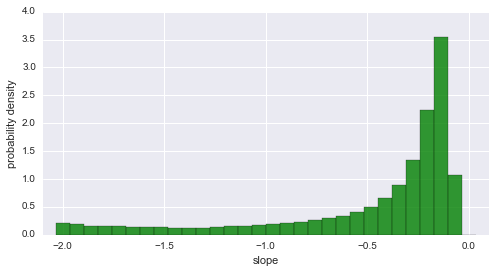

In [32]:
plt.figure(figsize=(8,4))
slope, slopeDist = CPS.plotHyperParameterDistribution('slope', color='g', alpha=.8)
plt.xlim([-2.1, 0.1]);

The plot above indicates that the decrease of the disaster rate is indeed a gradual process, as high probabilities are assigned to rather small slopes with an absolute value $<0.5$. However, there is still a significant probability of slopes with an absolute value that is larger than $0.5$. We may determine this value by integrating over the distribution:

In [33]:
dSlope = np.abs(slope[0] - slope[1]) # differential for integration
np.sum(slopeDist[np.abs(slope) > 0.5])*dSlope # integration = sum * differential

0.29278613851476459

More intuitive than the slope is the duration between the two structural breaks. This period of time directly measures the time it takes for the disaster rate to decrease from three to one disaster per year. The plot below shows the distribution for this period of time:

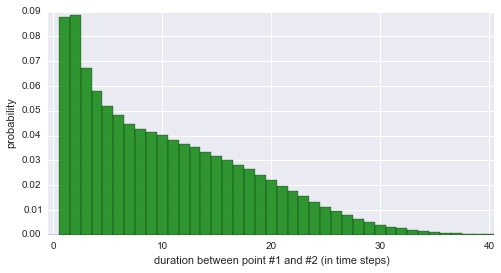

In [34]:
plt.figure(figsize=(8,4))
duration = CPS.plotDuration(color='g', alpha=.8, returnDistribution=True)
plt.xlim([-0.5,40.5]);

From this plot, we see that the period between the two structural breaks cannot be inferred with great accuracy. The accuracy may be improved by extending the simple serial model used in this example or by incorporating more data points (only 40 data points have been used here). We may still conclude that this analysis indicates an intermediate phase of improvement that is shorter than 15 years, with a probability of $\approx 70\%$:

In [35]:
np.sum(duration[:15])

0.71410799601878516

The results from the break-point analysis are further illustrated by the temproal evolution of the inferred disaster rate. Below, the average model of the complete analysis is used to display the inferred changes in the disaster rate:

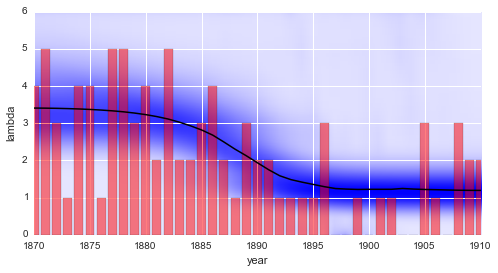

In [46]:
plt.figure(figsize=(8, 4))
plt.bar(range(1870, 1911), CPS.rawData, align='center', facecolor='r', alpha=.5)
CPS.plotParameterEvolution(param='lambda', xLower=1870, xUpper=1911)
plt.xlim([1870, 1910])
plt.xlabel('year')

<a id='section_6'></a>
## 6. Online study

For some applications, one is not necessarily interested in past parameter values, but instead needs a re-evaluation of the current parameter values as new data becomes available. *bayesloop* provides the `OnlineStudy` class to handle the analysis of live data streams. This class includes a `step` method that performs a single inference step based on one new data point. While only the current parameter distribution and mean values are stored, the class stores all data points for later analysis.

To provide an example for the usage of the `step` method, we iterate over all data points from the coal mining data set and subsequently plot the parameter distribution of the last year, 1962.

In [37]:
data = np.array([5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4,
                 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0,
                 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
                 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 3, 0,
                 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

OS = bl.OnlineStudy()

M = bl.om.Poisson()
OS.setObservationModel(M)

K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
OS.setTransitionModel(K)

OS.setGridSize([1000])
OS.setBoundaries([[0, 6]])

for d in data:
    OS.step(d)

+ Created new study.
  --> Online study
+ Observation model: Poisson. Parameter(s): ['lambda']
+ Transition model: Gaussian random walk
+ Grid size: [1000]
+ Boundaries: [[0, 6]]
    + Initialized flat prior distribution.
    + Updated posterior distribution. Data points: 1; Local evidence: 0.0924
    + Updated posterior distribution. Data points: 2; Local evidence: 0.1679
    + Updated posterior distribution. Data points: 3; Local evidence: 0.0748
    + Updated posterior distribution. Data points: 4; Local evidence: 0.0466
    + Updated posterior distribution. Data points: 5; Local evidence: 0.1296
    + Updated posterior distribution. Data points: 6; Local evidence: 0.2010
    + Updated posterior distribution. Data points: 7; Local evidence: 0.1527
    + Updated posterior distribution. Data points: 8; Local evidence: 0.0547
    + Updated posterior distribution. Data points: 9; Local evidence: 0.0398
    + Updated posterior distribution. Data points: 10; Local evidence: 0.2086
    + U

The resulting posterior distribution of the online study is stored in `oS.posteriorDistribution`, the mean value in `oS.posteriorMeanValue`:

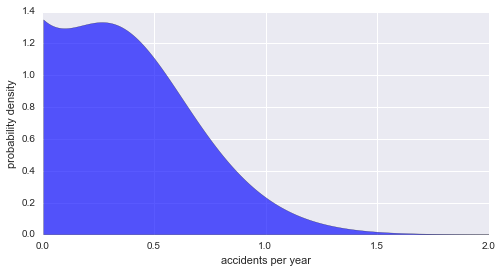

In [38]:
x = OS.grid[0]  # grid points for first (and only) parameter
y = OS.posteriorDistribution  # post. distr. is 1-dimensional in this case

y /= np.prod(OS.latticeConstant)  # normalize by grid-constant to get pdf instead of probability

plt.figure(figsize=(8,4))
plt.fill_between(x, 0, y, facecolor='b', alpha=.65)
plt.xlim([0, 2])
plt.xlabel('accidents per year')
plt.ylabel('probability density')

Apart from the `step` method, the `onlineStudy` class provides two additional methods to control online analyses. The `reset` method resets the current posterior distribution, posterior mean values and log-evidence. The `update` method can be called to re-evaluate the complete data set in the same way as the `step` method would. Note that the `fit` and `optimize` method are inherited from the `Study` class and may also be called within the online study.

<a id='section_7'></a>
## 7. Prior distributions

One important aspect of Bayesian inference has not yet been discussed in this tutorial: [prior distributions](https://en.wikipedia.org/wiki/Prior_probability). In Bayesian statistics, one has to provide probability (density) values for every possible parameter value *before* taking into account the data at hand. This prior distribution thus reflects all *prior* knowledge of the system that is to be investigated. In the case no prior knowledge is available, a *non-informative* prior in the form of the so-called [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) allows to minimize the effect of the prior on the results. The next two sub-sections discuss how one can set custom prior distributions for the parameters of the observation model and for hyper-parameters in a hyper-study or change-point study.

<a id='section_7.1'></a>
### 7.1 Parameter priors
*bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). This inference algorithm iteratively produces a parameter distribution for each time step, but it has to start these iterations from a specified probability distribution - the parameter prior. All built-in observation models already have a pre-defined prior, stored in the attribute `prior`. Here, the prior distribution is stored as a lambda-function that takes as many arguments as there are parameters in the observation model. The prior distributions can be looked up directly within `observationModels.py`. For the `Poisson` model discussed in this tutorial, the prior distribution is defined as
```
lambda x: np.sqrt(1./x)
```
corresponding to the non-informative Jeffreys prior, $p(\lambda) \propto 1/\sqrt{\lambda}$. This type of prior can also be determined automatically for arbitrary user-defined observation models, see [Sect. 8.1](#section_8.1).

To change the predefined prior of a given observation model, the `Study` class provides the `setPrior` method. There are two possible ways of defining a parameter prior in *bayesloop*: One is to provide a function that takes exactly as many arguments as there are parameters in the defined observation model. The following example defines a flat (uniform) prior for the `Poisson` model with only one parameter, using a lambda function:

In [39]:
S.setPrior(lambda x: 1)

+ Set custom prior: <lambda>


Note that all custom prior distributions are re-normalized by *bayesloop*, so they do not need to be passed in a normalized form.

The second option is based on the [SymPy](http://www.sympy.org/en/index.html) module that introduces symbolic mathematics to Python. Its sub-module [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) covers a wide range of discrete and continuous random variables. `setPrior` also accepts a list of `sympy.stats` random variables, one for each parameter (if there is only one parameter, the list can be omitted). The multiplicative joint probability density of these random variables is then used as the prior distribution. The following example defines an exponential prior for the `Poisson` model, favoring small values of the rate parameter: 

In [40]:
import sympy.stats
S.setPrior(sympy.stats.Exponential('expon', 1))

+ Set custom prior: exp(-x)


Note that one needs to assign a name to each `sympy.stats` variable. In this case, the output of *bayesloop* shows the mathematical formula that defines the prior. This is possible because of the symbolic representation of the prior by `SymPy`.

<a id='section_7.2'></a>
### 7.2 Hyper-parameter priors
As shown in Sects. [4](#section_4) and [5](#section_5), hyper-studies and change-point studies can be used to determine the full distribution of hyper-parameters (the parameters of the transition model). As for the *"regular"* parameters of the observation model, one might have prior knowledge about the values of certain hyper-parameters that can be included into the study to refine the resulting distribution of these hyper-parameters. Hyper-parameter priors can be defined just as regular priors, either by an arbitrary function or by a list of `sympy.stats` random variables.

In the case of a hyper-study, the number of arguments for the function or the number of random variables, respectively, is given by the number of hyper-parameters that are included in the hyper-grid, defined by the `setHyperGrid` method. The following example revisits the model from [Sect. 5.2](#section_5.2) with two break-points and a linear decrease with a varying slope as a hyper-parameter. 
```
import sympy.stats

S = bl.HyperStudy()
S.loadExampleData()

M = bl.observationModels.Poisson()
S.setObservationModel(M)

K = bl.tm.SerialTransitionModel(bl.tm.Static(),
                                15,
                                bl.tm.Linear(slope=-0.3),
                                30,
                                bl.tm.Static()
                                )
S.setTransitionModel(K)

S.setHyperGrid([['slope', -2.0, 0.0, 30]])
S.setHyperPrior(sympy.stats.Normal('slope_prior', -0.2, 0.4))

S.fit()
```
In this example, there is only one hyper-parameter - slope - for which we define a Normal distribution as the prior distribution, which is centered around the value -0.2 with a standard deviation of 0.4.

However, if we instead analyze the model above using a `ChangepointStudy`, the two break-points defined in the transition model are treated as hyper-parameters, too. Therefore, the prior distribution has to take three parameters into account. Using a lambda function, we can easily employ a flat (uniform) prior for the break-points, and again use a Normal prior for the slope hyper-parameter:
```
S = bl.ChangepointStudy()

...

S.setHyperGrid([['slope', -2.0, 0.0, 30]])
S.setHyperPrior(lambda b1, b2, slope: np.exp(-0.5*((slope + 0.2)/(2*0.4))**2)/0.4)

S.fit()
```
Note that the lambda function includes the break-points as arguments (`b1` and `b2`), but the result does not depend on them, i.e. the prior is flat regarding these two hyper-parameters. All custom hyper-parameter prior distributions are re-normalized by *bayesloop*, so they do not need to be passed in a normalized form.

<a id='section_8'></a>
## 8. Custom observation models

While *bayesloop* provides a number of observation models like `Poisson` or `AR1`, many applications call for different distributions, possibly with some parameters set to fixed values (e.g. with a mean value set to zero). The [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) and the [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html) modules include a large number of continuous as well as discrete probability distributions. The observation model class `Custom` allows to create observation models to be used in *bayesloop* studies on-the-fly, just by passing the desired `scipy.stats` distribution (and setting values for fixed parameters, if necessary), or by providing a `sympy.stats` random variable. Note that the `Custom` class can only be used to model statistically independent observations. Locally correlated time series (as described by the `AR1` model) still have to be defined manually by creating a custom class.

<a id='section_8.1'></a>
### 8.1 Sympy.stats random variables
The [SymPy](http://www.sympy.org/en/index.html) module introduces symbolic mathematics to Python. Its sub-module [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) covers a wide range of discrete and continuous random variables. In the following, we re-define the observation model of the coal mining study `S` defined above, but this time use the `sympy.stats` version of the poisson distribution:

In [41]:
import sympy.stats
from sympy import Symbol

lamda = Symbol('lambda', positive=True)
poisson = sympy.stats.Poisson('poisson', lamda)
M = bl.om.Custom(poisson)

+ Creating custom observation model based on random variable from SymPy.
    + Trying to determine Jeffreys prior. This might take a moment...
    + Successfully determined Jeffreys prior: 1/sqrt(lambda)


First, we specify the only parameter of the Poisson distribution (denoted $\lambda$) symbolically as a positive real number. Note that providing the keyword argument `positive=True` is important for `SymPy` to define the Poisson distribution correctly (not setting the keyword argument correctly results in a error). Having defined the parameter, a random variable based on the Poisson distribution is defined. This random variable is then passed to the `Custom` class of the *bayesloop* observation models.

Note that upon creating an instance of the observation model, *bayesloop* automatically determines the correct [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) for the Poisson model:
$$
p(\lambda) \propto 1/\sqrt{\lambda}
$$
This calculation is done symbolically and therefore represents an important advantage of using the `SymPy` module within *bayesloop*. This behavior can be turned off using the keyword argument `determineJeffreysPrior`, in case one wants to use a flat parameter prior instead or in the case that the automatic determination of the prior takes too long:
```
M = bl.om.Custom(poisson, determineJeffreysPrior=False)
```
See also [Sect. 7](#section_7) for further information on prior distributions. Having defined the observation model, it can be used for any type of study introduced above. Here, we reproduce the result of the [regime-switching example](#regime_switching_example) in [Sect. 5.1](#section_5.1). We find that the parameter distributions as well as the model evidence is identical - as expected:

+ Observation model: poisson. Parameter(s): ['lambda']
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -78.41558
    + Finished backward pass.
    + Computed mean parameter values.


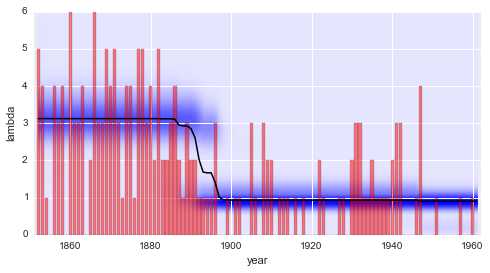

In [42]:
S.setObservationModel(M)
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='lambda', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

Finally, it is important to note that the `SymPy` module can also be used to create random variables for which some parameters have user-defined fixed values. The following example creates a normally distributed random variable with a fixed mean value $\mu = 4$, leaving only the standard deviation as a free parameter of the resulting observation model:
```
mu = 4
std = Symbol('stdev', positive=True)

normal = sympy.stats.Normal('normal', mu, std)
M = bl.om.Custom(normal)
```

<a id='section_8.2'></a>
### 8.2 Scipy.stats probability distributions
We continue by describing the use of probability distributions of the `scipy.stats` module. Before we show some usage examples, it is important to note here that `scipy.stats` does not use the canonical parameter names for probability distributions. Instead, all continuous distributions have two parameters denoted `loc` (for shifting the distribution) and `scale` (for scaling the distribution). Discrete distributions only support `loc`. While some distributions may have additional parameters, `loc` and `scale` often take the role of known parameters, like *mean* and *standard deviation* in case of the normal distribution. In `scipy.stats`, you do not have to set `loc` or `scale`, as they have default values `loc=0` and `scale=1`. In *bayesloop*, however, you will have to provide values for these parameters, if you want either of them to be fixed and not treated as a variable.

As a first example, we re-define the observation model of the coal mining study `S` defined above, but this time use the `scipy.stats` version of the poisson distribution. First, we check the parameter names:

In [43]:
import scipy.stats

scipy.stats.poisson.shapes

'mu'

In `scipy.stats`, the rate of events in one time interval of the poisson distribution is called *mu*. Additionally, as a discrete distribution, `stats.poisson` has an additional parameter `loc` (which is **not** shown by `.shapes` attribute!). As we do not want to shift the distribution, we have to set this parameter to zero in *bayesloop* by passing a dictionary for fixed parameters when initializing the class instance:

+ Creating custom observation model based on probability distribution from SciPy.
  ! A flat prior is used.
    Automatic determination of Jeffreys priors is only available for SymPy RVs.
+ Observation model: poisson. Parameter(s): ['mu']
+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -78.26874
    + Finished backward pass.
    + Computed mean parameter values.


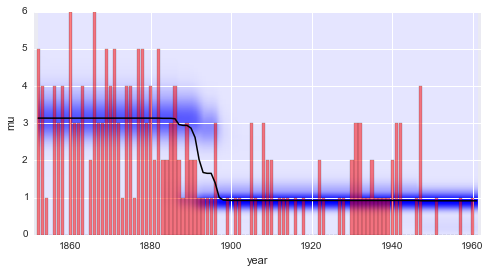

In [44]:
M = bl.observationModels.Custom(scipy.stats.poisson, fixedParameters={'loc': 0})
S.setObservationModel(M)
S.fit()

plt.figure(figsize=(8, 4))
plt.bar(range(1852, 1962), S.rawData, align='center', facecolor='r', alpha=.5)
S.plotParameterEvolution(param='mu', xLower=1852, xUpper=1962)
plt.xlim([1851, 1962])
plt.xlabel('year')

Comparing this result with the [regime-switching example](#regime_switching_example) in [Sect. 5.1](#section_5.1), we find that the model evidence value obtained using the `scipy.stats` implementation of the Poisson distribution is *different* from the value obtained using the built-in implementation or the `sympy.stats` version. The deviation is explained by a different prior distribution for the parameter $\lambda$. While both the built-in version and the `sympy.stats` version use the [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) of the Poisson model, the `scipy.stats` implementation uses a flat prior instead. Since the `scipy.stats` module does not provide symbolic representations of probability distributions, *bayesloop* cannot determine the correct Jeffreys prior in this case.

Finally, note that using the `scipy.stats` classes may increase the analysis run time slightly, compared to the built-in observation models.

<a id='section_9'></a>
## 9. Multiprocessing

Conducting extensive data studies based on the `HyperStudy` or `ChangepointStudy` classes may involve several 10000 or 100000 individual fits (see e.g. [Sect. 5.2](#section_5.2)). Since these individual fits with different hyper-parameter values are independent of each other, the computational workload may be distributed among the individual cores of a multi-core processor. To keep things simple, *bayesloop* uses [object serialization](https://docs.python.org/2/library/pickle.html) to create duplicates of the current `HyperStudy` or `ChangepointStudy` instance and distributes them across the pre-defined number of cores. In general, this procedure may be handled by the built-in Python module [multiprocessing](https://docs.python.org/2/library/multiprocessing.html). However, *multiprocessing* relies on the built-in module [pickle](https://docs.python.org/2/library/pickle.html) for object serialization, which fails to serialize the classes defined in *bayesloop*. We therefore use a different version of the *multiprocessing* module that is part of the [pathos](https://github.com/uqfoundation/pathos) module.

The latest version of *pathos* can be installed directly via [pip](https://pypi.python.org/pypi/pip), but requires [git](https://de.wikipedia.org/wiki/Git):
```
pip install git+https://github.com/uqfoundation/pathos
```
**Note**: Windows users need to install a C compiler *before* installing pathos. One possible solution for 64bit systems is to install [Microsoft Visual C++ 2008 SP1 Redistributable Package (x64)](http://www.microsoft.com/en-us/download/confirmation.aspx?id=2092) and [Microsoft Visual C++ Compiler for Python 2.7](http://www.microsoft.com/en-us/download/details.aspx?id=44266).

Once installed correctly, the number of cores to use in a hyper-study or change-point study can be specified by using the keyword argument `nJobs` within the `fit` method. Example (from [Sect 5.2](#section_5.2)):
```
CPS.fit(silent=True, nJobs=4)
```